In [1]:
import os
import re
import sys
import time
import random
import gensim
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords, words
STOPS = stopwords.words("english")

MODEL_FOLDER = 'models'

/home/admin/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
## Load Word2Vec model
model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary=True)

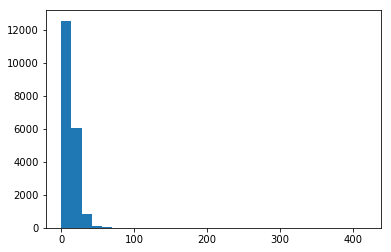

In [72]:
train_df = pd.read_csv('data/train.csv')

## Clean texts
def clean_text(text, model):
    """Takes in text and returns clean word list"""
    output = re.sub('[^a-zA-Z ]', '', text).lower()
    output = output.split(' ')
    output = [o for o in output if o not in STOPS and len(o) > 0 and o[:4] != 'http']
    output = [o for o in output if o in model.vocab]
    return output

train_df['text'] = train_df['text'].apply(clean_text, args=(model,))

## Choose a MAX_LEN
text_lengths = [len(t) for t in train_df['text'].tolist()]
plt.hist(text_lengths, bins=30)
MAX_LEN = 60

## Replace labels and split into train, test and validation sets
def replace_labels(author):
    label_dict = {'EAP': np.array([1, 0, 0]), 'HPL': np.array([0, 1, 0]), 'MWS': np.array([0, 0, 1])}
    return label_dict[author]

train_df['author'] = train_df['author'].apply(replace_labels)
train_df, test_df = train_test_split(train_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

In [37]:
train_df.head(n=5)

,id,text,author
2585,id26911,"[acting, natural, live]","[1, 0, 0]"
12823,id25908,"[silent, sun, set, far, hills, blazed, red, go...","[0, 1, 0]"
14686,id01435,"[illnesses, epoch, alarming, character, alarmi...","[1, 0, 0]"
6286,id25399,"[well, much, harangue, keep, running, instead,...","[0, 1, 0]"
18764,id23354,"[size, life, perfect, imitation, living, anima...","[1, 0, 0]"


In [73]:
## Get training matrices
def text2mat(clean_text, max_len):
    """Convert clean list of words from tweet into max_len x E matrix"""
    if len(clean_text) > max_len:
        clean_text = clean_text[:max_len]
    word_mat = [model[w] for w in clean_text]
    padding = [np.zeros(300)] * (max_len - len(word_mat))
    word_mat += padding
    word_mat = np.stack(word_mat, axis=0)
    return word_mat

def get_matrices(df):
    """Pass in test or train and return (?, max_len, E) X and (?) length vector y"""
    mat_list = [text2mat(t, max_len=MAX_LEN) for t in df['text'].tolist()]
    X = np.stack(mat_list, axis=0)
    y = np.stack(df['author'])
    return X, y

X_train, y_train = get_matrices(train_df)
print("Training data shape - X: {0}, y: {1}".format(X_train.shape, y_train.shape))
X_val, y_val = get_matrices(val_df)
print("Validation data shape - X: {0}, y: {1}".format(X_val.shape, y_val.shape))
X_test, y_test = get_matrices(test_df)
print("Test data shape - X: {0}, y: {1}".format(X_test.shape, y_test.shape))

Training data shape - X: (12530, 60, 300), y: (12530, 3)
Validation data shape - X: (3133, 60, 300), y: (3133, 3)
Test data shape - X: (3916, 60, 300), y: (3916, 3)


In [74]:
class CNNClassifier(object):
    def __init__(self, filter_sizes, num_filters, max_len, tf_model_folder, learning_rate, batch_size):
        self.tf_model_folder = tf_model_folder
        self.filter_sizes = filter_sizes
        self.num_filters = num_filters
        self.embedding_size = 300
        self.max_len = max_len
        self.num_filters_total = self.num_filters * len(self.filter_sizes)
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_classes = 3

        # Set up training parameters and TF placeholders
        self.x = tf.placeholder(dtype=tf.float32, shape=[None, self.max_len, self.embedding_size], name='x')
        self.y = tf.placeholder(dtype=tf.float32, shape=[None, self.n_classes], name='y')
        self.keep_prob = tf.placeholder(tf.float32)
        self.embeddings_net()
        
    def embeddings_net(self):
        x_expand = tf.expand_dims(self.x, -1)
        
#         W1 = tf.get_variable("W1", [32, 32],
#                              initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01))
#         W2 = tf.get_variable("W2", [32, 3],
#                              initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01))
#         b1 = tf.get_variable("b1", [32],
#                              initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01))
#         b2 = tf.get_variable("b2", [3],
#                              initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01))
        
#         # LSTM layer
# #         lstm = tf.contrib.rnn.BasicLSTMCell(num_units=32)
#         lstm = tf.nn.rnn_cell.BasicLSTMCell(num_units=32)
#         outputs, state = tf.nn.dynamic_rnn(cell=lstm, dtype=tf.float32, inputs=self.x)

#         # Linear layer + ReLU + linear layer
#         final_output = outputs[:, -1, :]
#         h1 = tf.nn.relu(tf.matmul(final_output, W1) + b1)
#         x_out = tf.matmul(h1, W2) + b2
#         self.y_pred = tf.nn.softmax(x_out)
        
        
        W_out = tf.get_variable("W_out", [self.num_filters_total, 3], 
            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01))
        b_out = tf.get_variable("b_out", [1], initializer=tf.constant_initializer(0.001))

        # Convolutions for s
        pooled_outputs = []
        for i, filter_size in enumerate(self.filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                filter_shape = [filter_size, self.embedding_size, 1, self.num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.01), name="W")
                b = tf.Variable(tf.constant(0.001, shape=[self.num_filters]), name="b")
                conv = tf.nn.conv2d(tf.cast(x_expand, tf.float32), W, 
                                    strides=[1, 1, 1, 1], padding="VALID", name="conv")
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                pooled = tf.nn.max_pool(h, ksize=[1, self.max_len-filter_size+1, 1, 1],
                                        strides=[1, 1, 1, 1], padding='VALID', name="pool")
                pooled_outputs.append(pooled)

        # Fully connected for s
        h_pool = tf.concat(pooled_outputs, 3)
        h_pool_flat = tf.reshape(h_pool, [-1, self.num_filters_total])
        h_pool_flat = tf.nn.dropout(h_pool_flat, self.keep_prob)
        x_out = tf.matmul(h_pool_flat, W_out) + b_out
        self.y_pred = tf.nn.softmax(x_out)
        
        # Compute target and incur loss
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y, logits=x_out))
#         self.acc = tf.reduce_ps 12sum(tf.cast(tf.equal(tf.round(self.y_pred), self.y), 'float'))
        self.opt = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss)
        
    def save_tf_model(self, tf_session, tf_saver):
        return tf_saver.save(tf_session, "/".join([self.tf_model_folder, "tf_model"]))

In [75]:
## Train model
# Hyper-parameters
filter_sizes = [1, 2, 3, 4]
num_filters = 5
learning_rate = 0.005
batch_size = 32
n_epochs = 20
dropout = 0.55
save_results_freq = 50

# Create graph
tf.reset_default_graph()
cnn = CNNClassifier(filter_sizes, num_filters, MAX_LEN, MODEL_FOLDER, learning_rate, batch_size)
saver = tf.train.Saver()

# Split into batches
X_train_batch_list = np.array_split(X_train, int(len(train_df)/batch_size))
y_train_batch_list = np.array_split(y_train, int(len(train_df)/batch_size))

# To print progress and store results throughout training
def progress_bar(value, endvalue, bar_length=20):
    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))
    sys.stdout.write("\rPercent complete: [{0}] {1}%".format(arrow + spaces, int(round(percent*100))))
    sys.stdout.flush()
    
train_results_dict = {
    'n_examples': [], 
    'batch_train_loss': [], 'validation_loss': []
}

# Start session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(n_epochs):
        print("#------- Running for epoch {} of {}".format(epoch+1, n_epochs))
        
        for i in range(len(X_train_batch_list)):
            progress_bar(i+1, len(X_train_batch_list))
            j = 0
            train_dict = {
                cnn.x: X_train_batch_list[i], 
                cnn.y: y_train_batch_list[i], 
                cnn.keep_prob: 1-dropout
            }
            opt, loss, pred = sess.run([cnn.opt, cnn.loss, cnn.y_pred], feed_dict=train_dict)
            
            if i % save_results_freq == 0:
                val_feed_dict = {cnn.x: X_val, cnn.y: y_val, cnn.keep_prob:1}
                loss_val = sess.run(cnn.loss, feed_dict=val_feed_dict)
                print("\tVal loss = {}".format(loss_val))
                
                train_results_dict['n_examples'].append(i * batch_size + epoch * len(y_train))
                train_results_dict['batch_train_loss'].append(loss)
                train_results_dict['validation_loss'].append(loss_val)
                
        all_train_dict = {cnn.x: X_train_batch_list[i], cnn.y: y_train_batch_list[i], cnn.keep_prob:1}
        loss_train = sess.run(cnn.loss, feed_dict=all_train_dict)
        print("\nTrained for {} epochs: train loss = {}".format(epoch+1, loss_train))
        
    cnn.save_tf_model(sess, saver)
    sess.close()

#------- Running for epoch 1 of 20
Percent complete: [>                   ] 0%	Val loss = 1.097347617149353
Percent complete: [-->                 ] 13%	Val loss = 1.033128261566162
Percent complete: [---->               ] 26%	Val loss = 0.9621013402938843
Percent complete: [------->            ] 39%	Val loss = 0.9347442984580994
Percent complete: [--------->          ] 51%	Val loss = 0.9179359674453735
Percent complete: [------------>       ] 64%	Val loss = 0.8863412141799927
Percent complete: [-------------->     ] 77%	Val loss = 0.8802177309989929
Percent complete: [----------------->  ] 90%	Val loss = 0.8772099018096924
Percent complete: [------------------->] 100%
Trained for 1 epochs: train loss = 0.8809593915939331
#------- Running for epoch 2 of 20
Percent complete: [>                   ] 0%	Val loss = 0.8573670387268066
Percent complete: [-->                 ] 13%	Val loss = 0.8513035774230957
Percent complete: [---->               ] 26%	Val loss = 0.8418809771537781
Percent c

KeyboardInterrupt: 